## TGF-β Signaling Pathway Model

This notebook studies parameters identifiability of the **TGF-β signaling pathway model** proposed in [Geier F, Fengos G, Felizzi F, Iber D. Analyzing and Constraining Signaling Networks](https://link.springer.com/book/10.1007%2F978-1-61779-833-7). Identifiability of this model was analyzed in this article \[\*\] [Parameter identifiability analysis and visualization in large-scale kinetic models of biosystems](https://bmcsystbiol.biomedcentral.com/articles/10.1186/s12918-017-0428-y). We used the equations and datasets provided by the authors of this article in the use-cases of [visid](https://github.com/gabora/visid) software. Our goal is to compare *CICOBase* results with the results of \[\*\]. 

The following ODE system defines the **TGF-β signaling pathway model**

In [12]:
using DiffEqBase, OrdinaryDiffEq, Sundials, CSV, Plots, NLopt, CICOBase, DataFrames
NLopt.srand(12345) # Set random seed for reproducibility of NLOpt

# ODE function
function ode_func(du,u,p,t)
    #parameters
    k1, k2, k4, k5, k6, k7, k8, k9, k10, k11, k12, k13, k14, k15, k16, k17, k18, k19 = p
    k3 = 0.01
    k20 = 9000.
    k21 = 1800.
    
    # concentrations (all concencentrations except I_Smad_mRNA1, I_Smad_mRNA2 are observed in the experiment)
    TGFb, TGFbR, TGFb_TGFbR, TGFb_TGFbR_P, I_Smad_TGFb_TGFbR_P, Smad, Smad_P, CoSmad, Smad_P_Smad_P, Smad_P_CoSmad, 
    Smad_N, Smad_P_Smad_P_N, Smad_P_N, Smad_P_CoSmad_N, CoSmad_N, I_Smad, I_Smad_mRNA1, I_Smad_mRNA2 = u

    # kinetic rates
    r1 = k1*TGFb_TGFbR                                   
    r2 = k2*TGFbR*TGFb                                   
    r3 = k3*TGFb_TGFbR*(1-exp(-((t-k20)/(k21))^10))      
    r4 = k4*TGFb_TGFbR_P                                 
    r5 = k5*TGFb_TGFbR_P*I_Smad                          
    r6 = k6*I_Smad_TGFb_TGFbR_P                          
    r7 = k7*Smad*TGFb_TGFbR_P                            
    r8 = k8*Smad                                         
    r9 = k9*Smad_N                                       
    r10 = k10*2*Smad_P*Smad_P                            
    r11 = k11*Smad_P_Smad_P                              
    r12 = k10*Smad_P*CoSmad                              
    r13 = k11*Smad_P_CoSmad                              
    r14 = k8*CoSmad                                      
    r15 = k9*CoSmad_N                                    
    r16 = k12*k8*Smad_P_Smad_P                           
    r17 = k8*Smad_P                                      
    r18 = k9*Smad_P_N                                    
    r19 = k12*k8*Smad_P_CoSmad                           
    r20 = k13*Smad_P_N                                   
    r21 = k10*2*Smad_P_N*Smad_P_N                        
    r22 = k11*Smad_P_Smad_P_N                            
    r23 = k10*Smad_P_N*CoSmad_N                          
    r24 = k11*Smad_P_CoSmad_N                            
    r25 = k14*Smad_P_CoSmad_N^2/(Smad_P_CoSmad_N^2+k15^2)
    r26 = k16*I_Smad_mRNA1                               
    r27 = k17*I_Smad_mRNA2                               
    r28 = k18*I_Smad_mRNA2                               
    r29 = k19*I_Smad                                     
        
    # rhs
    du[1] = r1-r2                                         
    du[2] = r1-r2                                        
    du[3] = -r1+r2-r3+r4+r6                         
    du[4] = r3-r4-r5                              
    du[5] = r5-r6                          
    du[6] = -r7-r8+r9                                    
    du[7] = r7-r10+r11-r12+r13-r17+r18                 
    du[8] = -r12+r13-r14+r15                           
    du[9] = r10-r11-r16                         
    du[10] = r12-r13-r19                         
    du[11] = r8-r9+r20                                  
    du[12] = r16+r21-r22                       
    du[13] = r17-r18-r20-r21+r22-r23+r24              
    du[14] = r19+r23-r24                       
    du[15] = r14-r15-r23+r24                          
    du[16] = r28-r29-r5+r6                    
    du[17] = r25-r26                            
    du[18] = r26-r27
end;

Initial conditions, estimated parameter values, and time points are taken from [visid repo](https://github.com/gabora/visid/blob/53c5f390f6b0459978c076ace01a4b5f7c165094/case_studies/tgfb/TGFB_amigo.m)

In [13]:
# initial conditions, nominal parameter values and timepoints
# https://github.com/gabora/visid/blob/master/case_studies/tgfb/TGFB_amigo.m
u0 = [
    1., 
    1., 
    -1.3645e-017, 
    -1.3645e-017, 
    -1.0333e-034, 
    40.976, 
    3.5121e-011, 
    34.146, 
    2.3805e-021, 
    -5.2419e-011, 
    19.024,
    1.0252e-018,
    6.218e-011,
    4.1486e-009,
    15.854,
    5.3131e-017,
    6.504e-017,
    3.7963e-017
]
    
p0 = [
    0.00015,
    0.023,
#    0.01, not estimated in fitting
    0.01,
    0.01,
    0.1,
    0.000404,
    0.0026,
    0.0056,
    0.002,
    0.016,
    5.7,
    0.00657,
    0.0017,
    1.,
    0.0008,
    0.001,
    0.0021,
    0.001
#    9000., not estimated in fitting
#    1800.  not estimated in fitting
]

time_points = [
    0.,
    1285.71,
    2571.43,
    3857.14,
    5142.86,
    6428.57,
    7714.29,
    9000.,
    10285.7,
    11571.4,
    12857.1,
    14142.9,
    15428.6,
    16714.3,
    18000.
]

# time interval to solve on
tspan = (0., 18000.);

Next we solve the IVP (Initial Value Problem)

In [14]:
# next we create an IVP 
prob = ODEProblem(ode_func, u0, tspan, p0)

# solver algorithm, tolerances and max iterations
solver_opts = Dict(
    :alg => AutoTsit5(Rosenbrock23()),
    :reltol => 1e-7,
    :abstol => 1e-7
)

# we are interested only in concentrations observed in the experiment, hence "save_idxs = 1:16"
sol = solve(
    prob, 
    solver_opts[:alg], 
    reltol=solver_opts[:reltol],
    abstol=solver_opts[:abstol],
    saveat=time_points,
    save_idxs = 1:16
);

We use pseudo-experimental dataset from [visid repo](https://github.com/gabora/visid/blob/53c5f390f6b0459978c076ace01a4b5f7c165094/case_studies/tgfb/TGFB_amigo.m) and plot one of the variables (TGFb) together with experimental data

In [15]:
dataset = CSV.read("TGFb_data.csv", DataFrame)

# standard deviation (sigma and not sigma^2!)
# provided in inputs.exps.error_data{iexp}
sigmas = CSV.read("TGFb_error.csv", DataFrame);

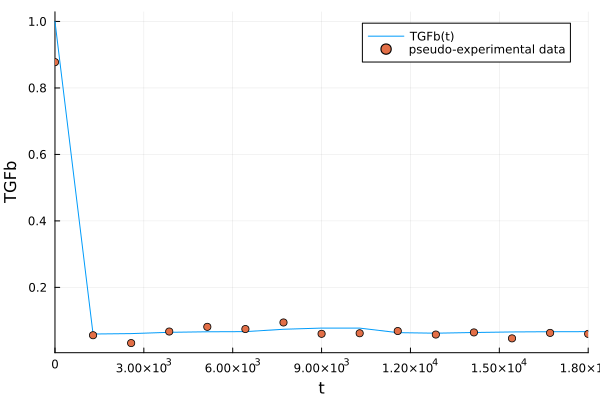

In [16]:
plot(sol, idxs=(0,1), xlabel = "t", ylabel = "TGFb", label="TGFb(t)");
scatter!(dataset[!,:time],dataset[!,:TGFb], label = "pseudo-experimental data")

To fit parameters to pseudo-experimental data we use the following likelihood function provided by the authors of \[\*\] in [AMIGO2 package](https://github.com/csynbiosys/AMIGO2R2016b). According to AMIGO2 docs:

*For the homoscedastic case, for which the variance is known or constant, the cost function results
to be similar to the generalized least squares, with weights taken as the inverse of the variance of
the experimental data*

$$ \Lambda = \sum_{i=1}^n \left(\frac{y(t_i) - \tilde y_i}{\sigma_i}\right)^2 $$

Here 
$n$ - number of observations (experimental data time points),
$\tilde y_i$ - experimental data,
$y(t_i)$ - numerical solution,
$\sigma_i $ - standard deviation of heteroscedastic noise

In [17]:
# loss function 
# for 'hetero' case 
# https://github.com/csynbiosys/AMIGO2R2016b/blob/63b131e0274096f9aef6ca42d0332ff113d1828a/Kernel/AMIGO_PEcost.m#L322

function loss_func(sol, data, sigma) # sum by components
    loss = 0.0
    for i in eachindex(sol.u[1]) #1:16
        loss += loss_i(sol[i,:], data[!,i+1], sigma[!,i+1])
    end
    return loss
end

function loss_i(sol, data, sigma) # sum by data points
    loss = 0.0  
    for i in eachindex(sol)
        loss += ((sol[i] - data[i])/sigma[i])^2
    end
    return loss 
end;

Objective function is a wrapper for parameters updates during fitting `obj_func = (params)->loss`

In [18]:
# obj function (params,prob)->loss
function obj_func(params;
                  prob=prob, 
                  solver_opts=solver_opts, 
                  time_points=time_points,
                  loss=(sol)->loss_func(sol,dataset,sigmas)
)
    prob_p = remake(prob,p=params)
    sol_p = solve(prob_p, 
                  solver_opts[:alg], 
                  reltol=solver_opts[:reltol], 
                  abstol=solver_opts[:abstol], 
                  saveat=time_points,
                  save_idxs = 1:16)
    loss(sol_p)
end;

Now we fit parameters to the dataset with *NLopt* package. See [NLopt documentation](https://nlopt.readthedocs.io/en/latest) for details

In [19]:
# fitting algorithm and search bounds

fitter_opts = Dict(
    :alg => :LN_SBPLX
)

# lower, upper bounds and start values formula:
# https://github.com/gabora/visid/blob/master/case_studies/tgfb/TGFB_amigo.m
lb = [1e-6, 0.0001, 1e-6, 0.0001, 1e-6, 1e-6, 1e-5, 1e-5, 1e-6, 1e-5, 0.1, 1e-5, 1e-5, 0.001, 1e-5, 1e-5, 1e-5, 1e-5]
ub = [0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 100., 1.0, 1.0, 100., 0.1, 0.1, 0.1, 0.1]

# start values generated with exp.(log.(lb) + rand(length(p0)).*(log.(ub) - log.(lb)))
p_start = [3.52E-05,
           0.00131226,
           0.00151732,
           0.0395871,
           1.63E-05,
           0.000251247,
           0.000112007,
           0.00783227,
           0.0424562,
           0.000142716,
           8.20992,
           0.000270499,
           0.0213893,
           1.41254,
           0.000121978,
           0.00658392,
           0.000205464,
           0.0111338]

opt = CICOBase.NLopt.Opt(fitter_opts[:alg], length(p0))
opt.min_objective = (p,grad) -> obj_func(p)
opt.lower_bounds = lb
opt.upper_bounds = ub
opt.xtol_rel = 1e-3

(loss,p,ret) = CICOBase.NLopt.optimize(opt, p_start)

(266.4304286862838, [0.0002290100323639326, 0.034062308265112966, 0.009190331178398126, 0.009397837818185099, 0.09984707196991427, 0.0003603781799218335, 0.0012436335138352544, 0.0027941738043466367, 0.001485713457196536, 0.011736726315087891, 9.135925727754511, 0.006429496691451377, 0.1503929163818522, 1.3782294060271663, 0.0007144737649710162, 0.0013187312206062762, 2.9047538654247835e-5, 0.0007398218861179926], :XTOL_REACHED)

Let's use *CICOBase* package to determine identifiable parameters and compute confidence intrvals.
We choose identification confidence level $ \alpha = loss + 3.84$, where $loss $ is the minimum likelihood function value obtained during fitting and 3.84 is *Chi-square statistics* with 1 degree of freedom and P-value=0.05.
Please, look up [CICOBase documentation](https://insysbio.github.io/CICOBase.jl/latest/) for details

In [20]:
α = loss + 3.84
scan_bounds = tuple.(lb/10,ub*10)
theta_bounds = tuple.(lb/100.,ub*100)

intervals = Vector{ParamInterval}(undef,length(p))
for i in eachindex(p)
    
    intervals[i] = get_interval(
        p,
        i,
        (p)->obj_func(p),
        :CICO_ONE_PASS,
        loss_crit = α,
        theta_bounds = theta_bounds,
        scan_bounds = scan_bounds[i],
        local_alg = :LN_SBPLX,
        #scale = fill(:log,length(p)),
        silent = true
    )
    display(intervals[i]) 
end

ParamInterval [0.0001959, 0.0002548] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.00019592579814263725
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 562
      supreme: 0.00019592579814263725
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.00025480125884828984
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 529
      supreme: 0.00025480125884828984


ParamInterval [0.02845, 0.04026] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.028449288110131192
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 719
      supreme: 0.028449288110131192
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.0402581106149024
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 592
      supreme: 0.0402581106149024


ParamInterval [0.008799, 0.009799] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.008799169652307332
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 729
      supreme: 0.008799169652307332
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.009798779335080728
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 799
      supreme: 0.009798779335080728


ParamInterval [0.008962, 0.009973] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.00896179470271066
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 673
      supreme: 0.00896179470271066
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.009972711736671877
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 878
      supreme: 0.009972711736671877


ParamInterval [0.09298, 0.1071] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.09297916034514314
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 701
      supreme: 0.09297916034514314
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.10712158818134494
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 480
      supreme: 0.10712158818134494


ParamInterval [0.0003492, 0.0003779] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.000349170111826034
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 609
      supreme: 0.000349170111826034
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.00037788184209084177
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 761
      supreme: 0.00037788184209084177


ParamInterval [0.00114, 0.001348] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.0011400970617217298
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 908
      supreme: 0.0011400970617217298
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.0013481295847610538
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 806
      supreme: 0.0013481295847610538


ParamInterval [0.0027, 0.003152] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.002700359160357181
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 643
      supreme: 0.002700359160357181
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.0031521152550768117
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 676
      supreme: 0.0031521152550768117


ParamInterval [0.001321, 0.001606] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.0013207785252008527
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 677
      supreme: 0.0013207785252008527
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.0016057574917872196
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 894
      supreme: 0.0016057574917872196


ParamInterval [0.01141, 0.01213] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.011409341073266379
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 1025
      supreme: 0.011409341073266379
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.012126992063162837
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 572
      supreme: 0.012126992063162837


ParamInterval [6.693, 9.568] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 6.693166001499397
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 5465
      supreme: 6.693166001499397
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 9.567708505780214
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 3129
      supreme: 9.567708505780214


ParamInterval [0.006238, 0.00676] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.006237695837818853
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 506
      supreme: 0.006237695837818853
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.006760165617290153
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 803
      supreme: 0.006760165617290153


ParamInterval [0.1237, 0.2138] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.12374908652901118
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 710
      supreme: 0.12374908652901118
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.21377400108026132
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 1857
      supreme: 0.21377400108026132


ParamInterval [1.276, 1.804] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 1.2758393595388418
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 696
      supreme: 1.2758393595388418
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 1.803927010440819
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 604
      supreme: 1.803927010440819


ParamInterval [0.0006514, 0.0007609] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.0006514177151797354
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 717
      supreme: 0.0006514177151797354
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.0007608753643956887
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 682
      supreme: 0.0007608753643956887


ParamInterval [0.001255, 0.001365] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.0012547570027940497
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 511
      supreme: 0.0012547570027940497
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.0013649281070707057
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 555
      supreme: 0.0013649281070707057


ParamInterval [2.71e-5, 3.187e-5] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 2.7098066543298524e-5
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 564
      supreme: 2.7098066543298524e-5
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 3.186884935592538e-5
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 533
      supreme: 3.186884935592538e-5


ParamInterval [0.0006887, 0.0007951] by :CICO_ONE_PASS
  loss_init: 266.4304286862838
  method: :CICO_ONE_PASS
  result:
    1: :left Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.0006886597977588877
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :left
      counter: 556
      supreme: 0.0006886597977588877
    2: :right Endpoint with status :BORDER_FOUND_BY_SCAN_TOL
      value: 0.0007950729264325051
      profilePoints count: 1
      status: :BORDER_FOUND_BY_SCAN_TOL
      direction: :right
      counter: 582
      supreme: 0.0007950729264325051


In [21]:
ENV["COLUMNS"]=140
df_res = DataFrame(
    Parameters = [:k1, :k2, :k4, :k5, :k6, :k7, :k8, :k9, :k10, :k11, :k12, :k13, :k14, :k15, :k16, :k17, :k18, :k19], 
    StatusLower = [k.result[1].status for k in intervals],
    StatusUpper = [k.result[2].status for k in intervals],
    CILower = [k.result[1].value for k in intervals],
    CIUpper = [k.result[2].value for k in intervals],
    FittedValues = p,
    StartValues = p_start,
    NominalValues = p0,
    NominalInCI = [(intervals[i].result[1].value <= p0[i] <= intervals[i].result[2].value) for i in eachindex(p0)]
)
df_res

Row,Parameters,StatusLower,StatusUpper,CILower,CIUpper,FittedValues,StartValues,NominalValues,NominalInCI
,Symbol,Symbol,Symbol,Float64,Float64,Float64,Float64,Float64,Bool
1,k1,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.000195926,0.000254801,0.00022901,3.52e-5,0.00015,false
2,k2,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.0284493,0.0402581,0.0340623,0.00131226,0.023,false
3,k4,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.00879917,0.00979878,0.00919033,0.00151732,0.01,false
4,k5,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.00896179,0.00997271,0.00939784,0.0395871,0.01,false
5,k6,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.0929792,0.107122,0.0998471,1.63e-5,0.1,true
6,k7,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.00034917,0.000377882,0.000360378,0.000251247,0.000404,false
7,k8,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.0011401,0.00134813,0.00124363,0.000112007,0.0026,false
8,k9,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.00270036,0.00315212,0.00279417,0.00783227,0.0056,false
9,k10,BORDER_FOUND_BY_SCAN_TOL,BORDER_FOUND_BY_SCAN_TOL,0.00132078,0.00160576,0.00148571,0.0424562,0.002,false
